In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import nlopt
import seaborn as sns
from statsrat import perform_oat, oat_grid, make_sim_data, learn_plot
from statsrat.expr.predef.cat import ibre, lrn_pred
from statsrat.rw.predef import smpr
from statsrat.rw import ard_linear, ard_probit, ard_probit_batch
from statsrat.rw.fbase import elem, elem_intercept
from scipy import stats
from plotnine import ggplot, geom_point, geom_line, aes, stat_smooth, facet_wrap

In [10]:
m = ard_linear.model(name = 'elemental ARD', fbase = elem)
pars = [-1, 15, 9, 1]
print(m.pars)
trials = ibre.make_trials()
ds = m.simulate(trials, par_val = pars)

                        min   max  default
prior_tausq_inv_hpar0 -20.0   0.0     -2.0
prior_tausq_inv_hpar1  -1.0  19.0      3.0
u_var                   0.0  10.0      0.1
resp_scale              0.0  10.0      1.0


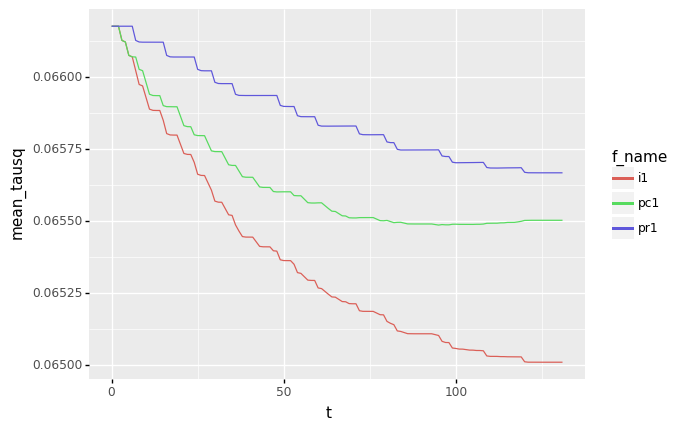

<ggplot: (310472557)>

In [11]:
var = 'mean_tausq'
learn_plot(ds, var, sel = {'f_name': ['pc1', 'pr1', 'i1']})

<xarray.DataArray 'mean_z' (t: 15, u_name: 2)>
array([[-1.47747475,  1.47747475],
       [-1.47747475,  1.47747475],
       [-1.47747475,  1.47747475],
       [-1.47747475,  1.47747475],
       [-1.47747475,  1.47747475],
       [-1.47747475,  1.47747475],
       [-1.47747475,  1.47747475],
       [-1.47747475,  1.47747475],
       [-1.47747475,  1.47747475],
       [-1.47747475,  1.47747475],
       [-1.47747475,  1.47747475],
       [-1.47747475,  1.47747475],
       [-1.47747475,  1.47747475],
       [-1.47747475,  1.47747475],
       [-1.47747475,  1.47747475]])
Coordinates:
  * t           (t) int64 5 14 17 26 36 46 51 60 70 76 80 91 100 107 114
    t_name      (t) <U4 'main' 'main' 'main' 'main' ... 'main' 'main' 'main'
    trial       (t) int64 5 14 17 26 36 46 51 60 70 76 80 91 100 107 114
    trial_name  (t) <U18 'i1.pr1 -> r1' 'i1.pr1 -> r1' ... 'i1.pr1 -> r1'
    stage       (t) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
    stage_name  (t) <U8 'training' 'training' ... 'training' 

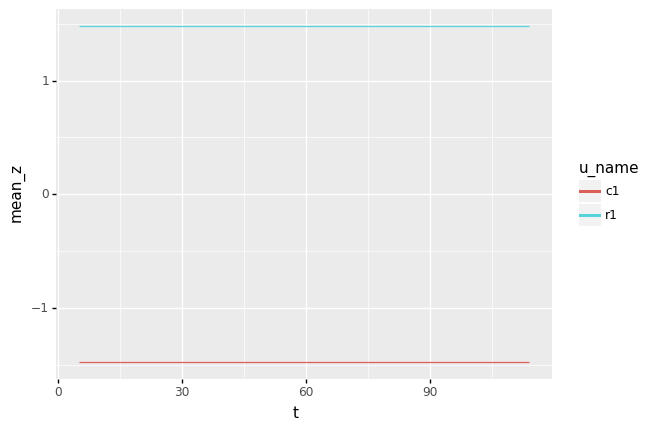

<ggplot: (305102797)>

In [15]:
var = 'mean_z'
index = ds.trial_name == 'i1.pr1 -> r1'
#index = ds.trial_name == 'i1.pc1 -> c1'
learn_plot(ds, var, sel = {'u_name': ['c1', 'r1'], 't': index})

In [10]:
var = 'mean_wsq'
learn_plot(ds, var, sel = {'f_name': ['pc1', 'pr1'], 'u_name': ['c1', 'r1']})

ValueError: list.remove(x): x not in list

In [18]:
# ordinal adequacy test (OAT) for the IBRE

n = 20
max_time = 120
#algorithm = nlopt.GN_DIRECT_L
algorithm = nlopt.GN_AGS
#algorithm = nlopt.GN_ORIG_DIRECT
#algorithm = nlopt.GD_STOGO

#m = ard_linear.model(name = 'elemental ARD', fbase = elem)
m = ard_probit.model(name = 'elemental ARD with intercept', fbase = elem_intercept)
#m = ard_probit_batch.model(name = 'elemental ARD', fbase = elem, n_itr = 10)

oat_result = perform_oat(m, ibre, minimize = False, n = n, max_time = max_time, algorithm = algorithm)
print(oat_result.round(5))

     prior_tausq_inv_hpar0  prior_tausq_inv_hpar1    mean   lower   upper
max                 -0.001                 18.999 -0.0024 -0.0024 -0.0024


In [2]:
pars = [-1, 5, 1]
trials = ibre.make_trials()
ds = m.simulate(trials, par_val = pars)
var = 'mean_tausq_inv'
learn_plot(ds, var, sel = {'f_name': ['pc1', 'pr1', 'i1']})
test_probs = ds['b_hat'].loc[ds.stage_name == 'test'].to_dataframe().reset_index()
mean_test_probs = test_probs.groupby(['trial_name', 'u_name'])['b_hat'].mean()
print(mean_test_probs)

NameError: name 'm' is not defined

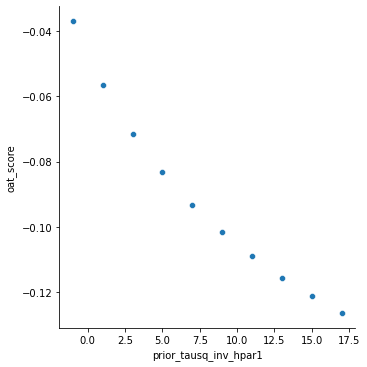

In [7]:
#m = ard_linear.model(name = 'elemental ARD', fbase = elem)
#free_par = 'u_var'
#fixed_values = {'prior_tausq_inv_hpar0': -3, 'prior_tausq_inv_hpar1': 0, 'resp_scale': 5}

m = ard_probit.model(name = 'elemental ARD', fbase = elem)
free_par = 'prior_tausq_inv_hpar1'
fixed_values = {'prior_tausq_inv_hpar0': -10, 'resp_scale': 5}

df = oat_grid(m,
              ibre,
              free_par = free_par,
              fixed_values = fixed_values,
              n_points = 5)
sns.relplot(x = free_par, y = 'oat_score', data = df)

In [5]:
# ordinal adequacy test (OAT) for learned predictiveness
oat_result = perform_oat(m, lrn_pred, n = n, max_time = max_time, algorithm = algorithm)
print(oat_result.round(5))

SystemError: PyEval_EvalFrameEx returned a result with an error set